In [534]:
# from networks.pdhg_tgv import PdhgTgvTorch, PdhgTgvNumpy
from PIL import Image
import matplotlib.pyplot as plt
from time import time

begin = time()
print(f"Importing torch ...")
import torch
from torch import nn
print(f"torch imported in {time()-begin:.2f} seconds")

import numpy as np
import scipy.ndimage
from PIL import Image
from skimage import data, img_as_float
from skimage.util import random_noise

# Run docstring tests
import doctest

from skimage.metrics import structural_similarity, peak_signal_noise_ratio

from tqdm.notebook import tqdm

Importing torch ...
torch imported in 0.00 seconds


In [535]:
# from networks.gradops.gradops_2 import dx_forward, dy_forward, dx_backward, dy_backward
from networks.gradops.gradops_1 import dx_forward, dy_forward, dx_backward, dy_backward

In [536]:
0.5 * (17 + np.sqrt(33))

11.372281323269014

In [537]:
1.0 / (0.5 * (17 + np.sqrt(33)))

0.08793310432392165

In [538]:
0.09 / 0.06

1.5

# PDHG TGV generic

In [539]:
class PdhgTgvSolver:
    """
    See page 17 in "Recovering piecewise smooth multichannel images..."
    https://unipub.uni-graz.at/obvugroa/content/titleinfo/125370
    """
    # Data-type-independent. User must ensure consistency.
    def __init__(
        self, 
        sigma, tau, nabla_h, e_h, div_h_v, div_h_w, P_alpha1, P_alpha0,
        convergence_limit
    ):
        print(f"convergence_limit: {convergence_limit}")
        excluded = ["self", "convergence_limit"]
        # Set all the attributes without repeating self.x = x
        for name, value in vars().items():
            if name not in excluded:
                setattr(self, name, value)
                
        # while self.sigma * self.tau < convergence_limit:
        #     self.sigma /= 2
        #     self.tau /= 2
        # print(f"sigma: {self.sigma}, tau: {self.tau}")
        # Tried:
        tried_sigma_tau_pairs_T_128 = [
            (0.3, 0.3), 
            (0.2, 0.5), 
            (0.1, 1),# 31.11391995617304
            (0.05, 0.2),
            (0.15, 0.6),# 30.982518791771238
            (0.1, 1.2),#best 31.141574519818178
            (0.1, 2),# 31.004992247700308
            (0.1, 1.6),# 30.99062095369552
            (0.06, 1.5),# 30.906473897629493
        ]
        tried_sigma_tau_pairs_T_256 = [
            (0.1, 1.2),# 31.019265618658387
        ]
        self.sigma = 0.1
        self.tau = 1.2
        
    def solve(self, u0, u, p, u_bar, p_bar, v, w, alpha1, alpha0, num_iters=100):
        # print(f"Using data-type-independent solver")
        
        for i in range(num_iters):
            # print("Iteration: ", i)
            v_next = self.P_alpha1(v + self.sigma * (self.nabla_h(u_bar) - p_bar), alpha1)
            
            w_next = self.P_alpha0(w + self.sigma * self.e_h(p), alpha0)
            
            u_next = self.id_tauFh_inverse(u + self.tau * self.div_h_v(v_next), u0)
            
            p_next = p + self.tau * (v_next + self.div_h_w(w_next))
            
            u_bar = u_next * 2 - u
            p_bar = p_next * 2 - p
            
            u, p = u_next, p_next
            v, w = v_next, w_next

        # del v_next, w_next # Explicitly free up memory
        # Don't free u_next and p_next, u_next is actually reference to u
            
        return u
        
    def id_tauFh_inverse(self, x, x0):
        """
        Resolvent operator (id + τ∂Fh)^(-1)
        See page 15 in "Recovering piecewise smooth multichannel...", 3.2 - A Numerical Algorithm 
        """
        # Placeholder for (id + τ∂Fh)^(-1)
        # return x
        # return x / self.tau
        # See page 19 in "Recovering piecewise smooth multichannel..."
        return (x + self.tau * x0) / (self.tau + 1)
    

# Gradient operators torch

In [540]:
class GradOpsTorch:
    def nabla_h(u):
        # $\Nabla_h$ and $\mathcal{E}_h$ ??? See page 13 in 'Recovering piecewise smooth multichannel...'
        # https://unipub.uni-graz.at/obvugroa/content/titleinfo/125370
        
        # Parameters
        # ----------
        # u : torch.Tensor
        #     Assume 2D tensor of shape [n, n] (for now).
            
        #     scalar field?
            
        # Returns
        # -------
        # grad_u : torch.Tensor
        #     Assume 3D tensor of shape [n, n, 2] (for now).
        #     The point is that, the shape of the output is one more dimension added to the end of input,
        #     and that extra last dimension is of size 2.
            
        #     Gradient of the scalar field u?
        # assert u.dim() == 2, f"u must be a 2D tensor, but got {u.dim()}D tensor"
        # Compute the gradient in both x and y directions
        
        """
        
        Example
        -------
        >>> u = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        >>> GradOpsTorch.backward_diff(u)
        tensor([[[1, 2, 3],
                 [3, 3, 3],
                 [1, 1, 1]],
        <BLANKLINE>
                [[1, 1, 1],
                 [1, 1, 1],
                 [1, 1, 1]]])
        """
        
        dx_f = dx_forward(u)
        dy_f = dy_forward(u)
        nabla_h_u = torch.stack([dx_f, dy_f], dim=-1)
        return nabla_h_u
    

    def e_h(v):
        assert len(v.shape) == 3, f"v must be a 3D tensor, but got {len(v.shape)}D tensor"
        assert v.shape[-1] == 2, f"v must have 2 channels in the last dimension, but got {v.shape[-1]} channels"
        dx_b_1 = dx_backward(v[..., 0])
        dy_b_1 = dy_backward(v[..., 0])
        dx_b_2 = dx_backward(v[..., 1])
        dy_b_2 = dy_backward(v[..., 1])
        # half = torch.tensor(0.5)
        # print(f"dx_b_1: {dx_b_1}, dy_b_1: {dy_b_1}, dx_b_2: {dx_b_2}, dy_b_2: {dy_b_2}")
        # w_1 = torch.tensor([dx_b_1, half * (dy_b_1 + dx_b_2)**2])
        # w_2 = torch.tensor([half * (dy_b_1 + dx_b_2)**2, dy_b_2])
        # w = torch.tensor([w_1, w_2])
        
        w = torch.stack(
            [
                torch.stack([dx_b_1, 0.5 * (dy_b_1 + dx_b_2)**2], dim=-1),
                torch.stack([0.5 * (dy_b_1 + dx_b_2)**2, dy_b_2], dim=-1)
            ],
            dim=-2
        )
        return w

    
    def div_h_v(v):
        """
        $\text{div}_h$. See page 14 in 'Recovering piecewise smooth multichannel...'
        https://unipub.uni-graz.at/obvugroa/content/titleinfo/125370
            
        Parameters
        ----------
        v : torch.Tensor
            Assume 3D tensor of shape [n, n, 2] (for now).
            The point is that, the shape of the input is one more dimension added to the end of the output,
            and that extra last dimension is of size 2.
            
            representing the vector field?
            
        Returns
        -------
        div_v : torch.Tensor
            Assume 2D tensor of shape [n, n] (for now).
            
            Divergence of the vector field v?
        """
        # assert v.dim() == 3, f"v must be a 3D tensor, but got {v.dim()}D tensor"
        # Compute the divergence from the gradient in both x and y directions
        dx_b_1 = dx_backward(v[..., 0])
        dy_b_2 = dy_backward(v[..., 1])
        div_h_v = dx_b_1 + dy_b_2
        return div_h_v
    
    def div_h_w(w):
        assert len(w.shape) == 4, f"w must be a 4D tensor, but got {len(w.shape)}D tensor"
        assert w.shape[-2] == 2, f"w must have 2 channels in the second last dimension, but got {w.shape[-2]} channels"
        assert w.shape[-1] == 2, f"w must have 2 channels in the last dimension, but got {w.shape[-1]} channels"
        dx_f_11 = dx_forward(w[..., 0, 0])
        dy_f_22 = dy_forward(w[..., 1, 1])
        dx_f_12 = dx_forward(w[..., 0, 1])
        dy_f_12 = dy_forward(w[..., 0, 1])
        v_1 = dx_f_11 + dy_f_12
        v_2 = dx_f_12 + dy_f_22
        v = torch.stack(
            [
                v_1, v_2
            ],
            dim=-1
        )
        return v

# Example arrays

In [541]:
def get_example_arrays():
    return (
        [
            [1, 2, 3], 
            [4, 5, 6], 
            [7, 8, 9]
        ],
        [
            [[1, 1], [2, 2], [3, 3]],
            [[4, 4], [5, 5], [6, 6]],
            [[7, 7], [8, 8], [9, 9]]
        ]
    )
    
def test_finite_difference():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    u, p = get_example_arrays()
    u = torch.tensor(u, device=device)
    p = torch.tensor(p, device=device)
    print(f"u.shape = {u.shape}, p.shape = {p.shape}")
    print(f"u = \n{u}")
    print(f"p = \n{p}")

    nabla_h_u = GradOpsTorch.nabla_h(u)
    print(f"nable_h_u.shape = {nabla_h_u.shape}")
    print(f"nabla_h_u = \n{nabla_h_u}")
    
    e_h_v = GradOpsTorch.e_h(p)
    print(f"e_h_v.shape = {e_h_v.shape}")
    print(f"e_h_v = \n{e_h_v}")
    
test_finite_difference()

u.shape = torch.Size([3, 3]), p.shape = torch.Size([3, 3, 2])
u = 
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], device='cuda:0')
p = 
tensor([[[1, 1],
         [2, 2],
         [3, 3]],

        [[4, 4],
         [5, 5],
         [6, 6]],

        [[7, 7],
         [8, 8],
         [9, 9]]], device='cuda:0')
nable_h_u.shape = torch.Size([3, 3, 2])
nabla_h_u = 
tensor([[[ 3.,  1.],
         [ 3.,  1.],
         [ 3., -3.]],

        [[ 3.,  1.],
         [ 3.,  1.],
         [ 3., -6.]],

        [[-7.,  1.],
         [-8.,  1.],
         [-9., -9.]]], device='cuda:0')
e_h_v.shape = torch.Size([3, 3, 2, 2])
e_h_v = 
tensor([[[[ 1.0000,  2.0000],
          [ 2.0000,  1.0000]],

         [[ 2.0000,  4.5000],
          [ 4.5000,  1.0000]],

         [[ 3.0000,  8.0000],
          [ 8.0000,  1.0000]]],


        [[[ 3.0000, 24.5000],
          [24.5000,  4.0000]],

         [[ 3.0000,  8.0000],
          [ 8.0000,  1.0000]],

         [[ 3.0000,  8.0000],
          [ 8.0000,  1

# PDHG TGV torch

In [542]:
class PdhgTgvTorch(nn.Module):
    # See page 17 in "Recovering piecewise smooth multichannel..." for the algorithm
    def __init__(self, device):
        super(PdhgTgvTorch, self).__init__() # Ensure proper initialisation
        self.device = device
        self.sigma = torch.tensor(1.0, device=device)
        self.tau = torch.tensor(1.0, device=device)
        self.theta = torch.tensor(1.0, device=device)

        # Norm of K. See page 16 in "Recovering piecewise smooth multichannel..."
        convergence_limit = 1.0 / (0.5 * (17 + torch.sqrt(torch.tensor(33.0, device=device))))
        # TODO: Change this for the 2D static greyscale image denoising problem
        
        self.pdhg_tgv_solver = PdhgTgvSolver(
            sigma=self.sigma,
            tau=self.tau,
            nabla_h=GradOpsTorch.nabla_h,
            e_h=GradOpsTorch.e_h,
            div_h_v=GradOpsTorch.div_h_v,
            div_h_w=GradOpsTorch.div_h_w,
            P_alpha1=self.P_alpha1,
            P_alpha0=self.P_alpha0,
            convergence_limit=convergence_limit
        )

    def solve(self, u, p, alpha1, alpha0, num_iters=100):
        """
        Wrapper for the forward method.
        Only adding the device management.
        """
        old_device = u.device
        u = self.forward(u.to(self.device), p.to(self.device), alpha1, alpha0, num_iters)
        return u.to(old_device)

    def forward(self, u, p, alpha1, alpha0, num_iters=100):
        """
        
        Parameters
        ----------
        u0 : torch.Tensor
            Initial guess for the solution u (denoised image). 
            Expect 2D tensor of shape [n, n] (for now).
            
        p0 : torch.Tensor
            Initial guess for the solution p?
            Expect 3D tensor of shape [n, n, 2] (for now).
            The point is that, the shape of p0 is one more dimension added to the end of u0,
            and that extra last dimension is of size 2.
            
        alpha1 : float or torch.Tensor
            The regularization scalar parameter or parameters map.
            It is the threshold for the projection operator P_alpha1 (in this case)?
            
        alpha0 : float or torch.Tensor
            The regularization scalar parameter or parameters map.
            It is the threshold for the projection operator P_alpha0 (in this case)?
        """
        device = self.device
        u0 = u.clone() # 2D shape = [n, n]
        
        # p = p.to(device)
        # # Change shape from [n, n] to [n, n, 2] for grad_h(u0) and grad_h(p0)
        # p = p.unsqueeze(-1).expand(-1, -1, 2) # shape = [n, n, 2]
        v = torch.zeros(u.shape + (2,), device=device) # Adjusted to match gradient size [n, n, 2]
        w = torch.zeros(p.shape + (2,), device=device) # Adjusted to match gradient size [n, n, 2, 2]
        
        u_bar = u.clone() # 2D shape = [n, n]
        
        p_bar = p.clone() # 3D shape = [n, n, 2]

        u = self.pdhg_tgv_solver.solve(u0, u, p, u_bar, p_bar, v, w, alpha1, alpha0, num_iters)
                
        del u_bar, p_bar, v, w
        # del v_next, w_next, u_next, p_next

        return u
    
    def pointwise_norm2(self, v, dim):
        norm_2_v = torch.sqrt(torch.sum(v**2, dim=dim))
        return norm_2_v
    
    def P_alpha(self, x, alpha, dim):
        # Projection
        # return x.clamp(-alpha, alpha) # Thresholding / Clip act
        # See page 16 in "Recovering piecewise smooth multichannel..."
        norm = self.pointwise_norm2(x, dim)
        norm_max_element = torch.max(norm)
        one = torch.tensor(1.0, device=self.device)
        return x / torch.max(one, norm_max_element / alpha)
    
    def P_alpha1(self, v, alpha1):
        return self.P_alpha(v, alpha1, dim=(-1,))
    
    def P_alpha0(self, w, alpha0):
        return self.P_alpha(w, alpha0, dim=(-1, -2))
    

In [543]:
doctest.testmod()

**********************************************************************
File "__main__", line 8, in __main__.GradOpsTorch.nabla_h
Failed example:
    GradOpsTorch.backward_diff(u)
Exception raised:
    Traceback (most recent call last):
      File "/usr/lib/python3.10/doctest.py", line 1350, in __run
        exec(compile(example.source, filename, "single",
      File "<doctest __main__.GradOpsTorch.nabla_h[1]>", line 1, in <module>
        GradOpsTorch.backward_diff(u)
    AttributeError: type object 'GradOpsTorch' has no attribute 'backward_diff'
**********************************************************************
1 items had failures:
   1 of   2 in __main__.GradOpsTorch.nabla_h
***Test Failed*** 1 failures.


TestResults(failed=1, attempted=2)

# Plot results

In [544]:
def plot_results(img_np, noisy_img_np, denoised_img_np):
    img_PIL = Image.fromarray((img_np * 255).astype(np.uint8))
    noisy_img_PIL = Image.fromarray((noisy_img_np * 255).astype(np.uint8))
    denoised_img_PIL = Image.fromarray((denoised_img_np * 255).astype(np.uint8))
    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_PIL, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(noisy_img_PIL, cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[1].axis('off')
    ax[2].imshow(denoised_img_PIL, cmap='gray')
    ax[2].set_title('Denoised Image')
    ax[2].axis('off')
    plt.show()

# Example usage

In [545]:
# Example usage:
def test_pdhg_tgv_torch():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # u = torch.zeros((10, 10), device=device) # Assume 2D tensor of shape [n, n] (for now)
    # p = torch.zeros((10, 10, 2), device=device) # Assume 3D tensor of shape [n, n, 2] (for now)
    
    u, p = get_example_arrays()
    u = torch.tensor(u, device=device)
    p = torch.tensor(p, device=device)
    print(f"u.shape = {u.shape}, p.shape = {p.shape}")
    print(f"u = \n{u}")
    print(f"p = \n{p}")
    
    model = PdhgTgvTorch(device=device)

    uN = model(u, p, alpha1=0.5, alpha0=0.5, num_iters=3)
    print(uN)

test_pdhg_tgv_torch()

u.shape = torch.Size([3, 3]), p.shape = torch.Size([3, 3, 2])
u = 
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], device='cuda:0')
p = 
tensor([[[1, 1],
         [2, 2],
         [3, 3]],

        [[4, 4],
         [5, 5],
         [6, 6]],

        [[7, 7],
         [8, 8],
         [9, 9]]], device='cuda:0')
convergence_limit: 0.08793310821056366
tensor([[1.0237, 2.0031, 2.9137],
        [3.8900, 4.9289, 5.8008],
        [6.6880, 7.7131, 8.5453]], device='cuda:0')


# Load stuff

In [546]:
device = "cuda"
model = PdhgTgvTorch(device=device)

# # Load sample image
# clean_img_np = img_as_float(data.camera())    
# noisy_img_np = random_noise(clean_img_np, mode='gaussian', var=0.01)
# clean_2d = torch.tensor(clean_img_np, device=device)
# noisy_2d = torch.tensor(noisy_img_np, device=device)

size = 256
sigma = "0_05"
inner_folder_clean = f"images_crop_resize_{size}_greyscale"
inner_folder_noisy = f"images_crop_resize_{size}_greyscale_noisy_{sigma}"
data_folder = f"../../data/turtle_id_2022/turtles-data/data/"
results_folder = f"../../turtle_id/test/test_reg_map"
example_file_name = f"t008/PaXakrkxqN"
extension = "JPG"
example_clean_file = f"{inner_folder_clean}/{example_file_name}.{extension}"
example_noisy_file = f"{inner_folder_noisy}/{example_file_name}.{extension}"
example_clean_file_path = f"{data_folder}/{example_clean_file}"
example_noisy_file_path = f"{data_folder}/{example_noisy_file}"

example_reg_map_denoised = f"test/{inner_folder_noisy}/{example_file_name}/denoised.png"
example_scalar_reg_denoised = f"test/{inner_folder_noisy}/{example_file_name}/scalar/best_PSNR.png"

clean_img = Image.open(example_clean_file_path)
clean_img = np.array(clean_img, dtype=np.float32) / 255.0
clean_img = torch.tensor(clean_img).to(device)
print(f"clean_img.shape = {clean_img.shape}")


noisy_img_path = example_noisy_file_path

noisy_img = Image.open(noisy_img_path)
noisy_img = np.array(noisy_img, dtype=np.float32) / 255.0
noisy_img = torch.tensor(noisy_img).to(device)
noisy_2d = noisy_img

clean_img_np = clean_img.cpu().numpy()
noisy_img_np = noisy_img.cpu().numpy()

print(f"clean_img_np.shape = {clean_img_np.shape}")
print(f"noisy_img_np.shape = {noisy_img_np.shape}")

convergence_limit: 0.08793310821056366
clean_img.shape = torch.Size([256, 256])
clean_img_np.shape = (256, 256)
noisy_img_np.shape = (256, 256)


# Plot pre-generate

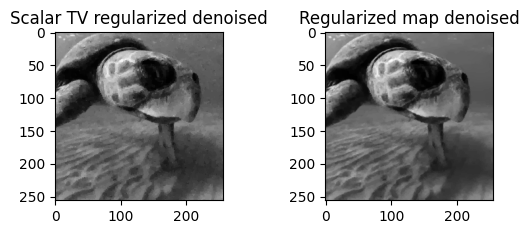

In [547]:
def plot_pre_generated():
    model = "06_24_19_56_05-50"
    reg_map_denoised = f"{results_folder}/{model}/{example_reg_map_denoised}"
    scalar_reg_denoised = f"{results_folder}/{model}/{example_scalar_reg_denoised}"
    
    scalar_reg_denoised_img = Image.open(scalar_reg_denoised)
    plt.subplot(2, 2, 3)
    plt.imshow(scalar_reg_denoised_img, cmap="gray")
    # scalar_reg_denoised_img.show()
    plt.title("Scalar TV regularized denoised")
    # plt.show()
    
    reg_map_denoised_img = Image.open(reg_map_denoised)
    plt.subplot(2, 2, 4)
    plt.imshow(reg_map_denoised_img, cmap="gray")
    # reg_map_denoised_img.show()
    plt.title("Regularized map denoised")
    # plt.show()
    
plot_pre_generated()


# Test torch

img.shape = torch.Size([256, 256])
convergence_limit: 0.08793310821056366
min: 0.020489126443862915, max: 0.7761470079421997
Done 128 iterations


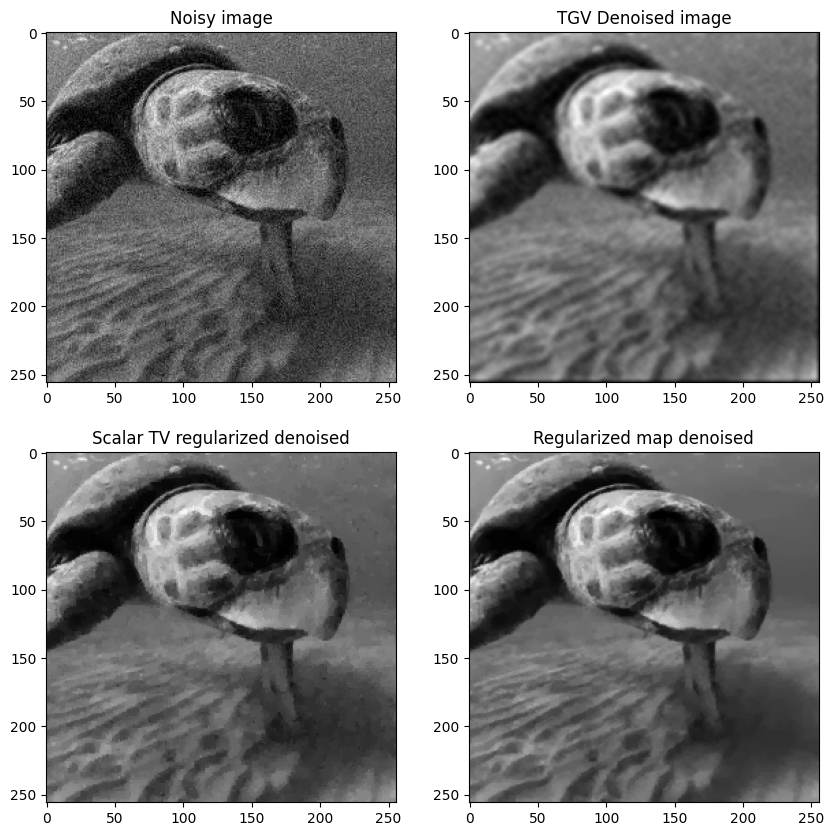

In [563]:
def test_pdhg_tgv_torch_on_image(file:str, alpha1, alpha0, num_iters):
    img_path = file
    img = Image.open(img_path)
    img = np.array(img, dtype=np.float32) / 255.0
    img = torch.tensor(img)
    
    plt.figure(figsize=(10, 10))
    
    print(f"img.shape = {img.shape}")
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Noisy image")
    # plt.show()
    
    device = "cuda"
    model = PdhgTgvTorch(device=device)
    
    u = img.clone()
    p = torch.zeros((img.shape[0], img.shape[1], 2))
    # p = np.copy(img)
    # p = p[..., np.newaxis]
    
    uN = model.solve(u, p, alpha1=alpha1, alpha0=alpha0, num_iters=num_iters)
    print(f"min: {uN.min()}, max: {uN.max()}")
    uN = uN.clamp(0, 1)
    print(f"Done {num_iters} iterations")
    plt.subplot(2, 2, 2)
    plt.imshow(uN, cmap="gray")
    plt.title("TGV Denoised image")
    # plt.show()

    plot_pre_generated()
    plt.show()
    
    assert not torch.allclose(u, uN), f"NO CHANGE"
    
test_pdhg_tgv_torch_on_image(
    file=example_noisy_file_path,
    alpha1=0.5,
    alpha0=0.3,
    num_iters=128
)

# Is valid image

In [549]:
def is_valid_image(img):
    min_pixel = np.min(img)
    max_pixel = np.max(img)
    min_pixel = round(min_pixel * 255)
    max_pixel = round(max_pixel * 255)
    # print(f"Min pixel value: {min_pixel}")
    # print(f"Max pixel value: {max_pixel}")
    return min_pixel >= 0 and max_pixel <= 255

# TGV denoising

In [550]:
def tgv_denoising(alpha0, alpha1):
    p = torch.zeros((clean_img_np.shape[0], clean_img_np.shape[1], 2), device=device)
    denoised_2d = model(u=noisy_2d, p=p, alpha1=alpha1, alpha0=alpha0, num_iters=128)
    denoised_img_np = denoised_2d.cpu().detach().numpy()
    return denoised_img_np

# Ternary search

In [551]:
def ternary_search_2d(min_x, max_x, min_y, max_y, compute, is_best, num_iters):
    assert min_x < max_x, f"min_x: {min_x}, max_x: {max_x}"
    assert min_y < max_y, f"min_y: {min_y}, max_y: {max_y}"
    for _ in tqdm(range(num_iters)):
        mid_x_1 = min_x + (max_x - min_x) / 3
        mid_x_2 = min_x + 2 * (max_x - min_x) / 3
        mid_y_1 = min_y + (max_y - min_y) / 3
        mid_y_2 = min_y + 2 * (max_y - min_y) / 3
        res_x1_y1 = compute(mid_x_1, mid_y_1)
        res_x1_y2 = compute(mid_x_1, mid_y_2)
        res_x2_y1 = compute(mid_x_2, mid_y_1)
        res_x2_y2 = compute(mid_x_2, mid_y_2)
        print(f"{res_x1_y1} {res_x1_y2} {res_x2_y1} {res_x2_y2}")
        max_res = is_best(res_x1_y1, res_x1_y2, res_x2_y1, res_x2_y2)
        if max_res == res_x1_y1:
            max_x = mid_x_2
            max_y = mid_y_2
            print(f"1: {max_res}")
        elif max_res == res_x1_y2:
            max_x = mid_x_2
            min_y = mid_y_1
            print(f"2: {max_res}")
        elif max_res == res_x2_y1:
            min_x = mid_x_1
            max_y = mid_y_2
            print(f"3: {max_res}")
        elif max_res == res_x2_y2:
            min_x = mid_x_1
            min_y = mid_y_1
            print(f"4: {max_res}")
        print(f"min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}")
    return (min_x + max_x) / 2, (min_y + max_y) / 2

# Get PSNR

In [552]:
def get_psnr(alpha0, alpha1):
    denoised_img_np = tgv_denoising(alpha0=alpha0, alpha1=alpha1)
    
    if is_valid_image(denoised_img_np):
        psnr = peak_signal_noise_ratio(clean_img_np, denoised_img_np)
    else:
        psnr = 0
    # print(f"PSNR: {psnr}")
    
    # denoised_img_PIL = Image.fromarray((denoised_img_np * 255).astype(np.uint8))
    # plt.imshow(denoised_img_PIL, cmap='gray')
    # plt.axis('off')
    # plt.show()
    
    return psnr

# Do ternary search

  0%|          | 0/30 [00:00<?, ?it/s]

29.21304301084276 29.21304301084276 29.91072966022671 27.181327532107087
3: 29.91072966022671
min_x: 0.334, max_x: 1, min_y: 0.001, max_y: 0.667
30.760902913381436 28.147214144876536 30.760902913381436 28.472994335110812
1: 30.760902913381436
min_x: 0.334, max_x: 0.778, min_y: 0.001, max_y: 0.445
30.834667446758658 30.31150453287936 30.90694284724438 30.302865658063247
3: 30.90694284724438
min_x: 0.482, max_x: 0.778, min_y: 0.001, max_y: 0.297
25.622181082876217 30.756516645824572 25.608220589214632 30.756516645824572
2: 30.756516645824572
min_x: 0.482, max_x: 0.6793333333333333, min_y: 0.09966666666666667, max_y: 0.297
30.934937292667556 30.741128363857303 31.0784069722368 30.741128363857303
3: 31.0784069722368
min_x: 0.5477777777777778, max_x: 0.6793333333333333, min_y: 0.09966666666666667, max_y: 0.23122222222222222
30.847293586137038 30.71972525093169 25.939443616563757 30.719722992021538
1: 30.847293586137038
min_x: 0.5477777777777778, max_x: 0.6354814814814815, min_y: 0.099666666

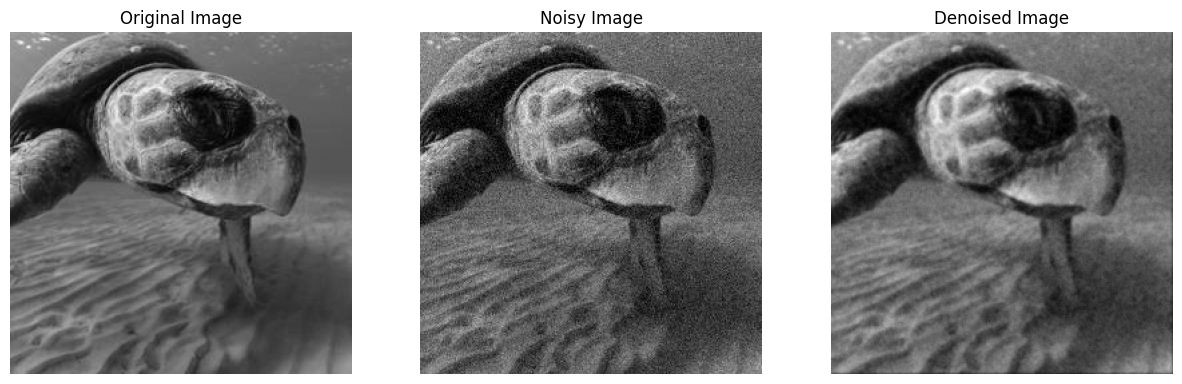

best_alpha0: 0.6354788765415036
best_alpha1: 0.16156957985982334


In [553]:
best_alpha0, best_alpha1 = ternary_search_2d(
    1e-3, 1, 1e-3, 1, 
    get_psnr, max, 30)

best_denoised_img_np = tgv_denoising(alpha0=best_alpha0, alpha1=best_alpha1)

plot_results(clean_img_np, noisy_img_np, best_denoised_img_np)

print(f"best_alpha0: {best_alpha0}")
print(f"best_alpha1: {best_alpha1}")

# PDHG TGV numpy

In [554]:
# class PdhgTgvNumpy():
#     def __init__(self):
#         self.sigma = 1.0
#         self.tau = 1.0
#         self.theta = 1.0
        
#         # Norm of K. See page 16 in "Recovering piecewise smooth multichannel..."
#         convergence_limit = 1.0 / (0.5 * (17 + np.sqrt(33)))
            
#         self.pdhg_tgv_solver = PdhgTgvSolver(
#             sigma=self.sigma,
#             tau=self.tau,
#             grad_h=self.grad_h,
#             div_h=self.div_h,
#             P_alpha1=self.P_alpha1,
#             P_alpha0=self.P_alpha0,
#             convergence_limit=convergence_limit
#         )
            
#     def solve(self, u, p, alpha1, alpha0, num_iters=100):
#         u0 = u.copy()
#         u_bar = u.copy()
#         p_bar = p.copy()
        
#         v = np.zeros(u.shape + (2,))
#         w = np.zeros(p.shape + (2,))
        
#         u = self.pdhg_tgv_solver.solve(u0, u, p, u_bar, p_bar, v, w, alpha1, alpha0, num_iters)
        
#         return u
    
#     def grad_h(self, u):
#         """
        
#         Parameters
#         ----------
#         u : np.ndarray
#             Assume 2D tensor of shape [n, n] (for now).
            
#             scalar field?
            
#         Returns
#         -------
#         grad_u : np.ndarray
#             Assume 3D tensor of shape [n, n, 2] (for now).
#             The point is that, the shape of the output is one more dimension added to the end of input,
#             and that extra last dimension is of size 2.
            
#             Gradient of the scalar field u?
#         """
#         # assert u.ndim == 2, f"u must be a 2D, but got {u.ndim}D"
#         # Compute the gradient in both x and y directions
#         grad_u = np.zeros(u.shape + (2,))
#         grad_u[..., 0] = np.diff(u, axis=0, append=u[-1:, ...])
#         grad_u[..., 1] = np.diff(u, axis=1, append=u[:, -1:])
#         return grad_u
    
#     def div_h(self, v):
#         """
        
#         Parameters
#         ----------
#         v : np.ndarray
#             Assume 3D tensor of shape [n, n, 2] (for now).
#             The point is that, the shape of the input is one more dimension added to the end of the output,
#             and that extra last dimension is of size 2.
            
#             representing the vector field?
            
#         Returns
#         -------
#         div_v : np.ndarray
#             Assume 2D tensor of shape [n, n] (for now).
            
#             Divergence of the vector field v?
#         """
#         # assert v.ndim == 3, f"v must be a 3D, but got {v.ndim}D"
#         # Compute the divergence from the gradient in both x and y directions
#         div_v = np.zeros(v.shape[:-1])
#         div_v += np.diff(v[..., 0], axis=0, prepend=v[0:1, ..., 0])
#         div_v += np.diff(v[..., 1], axis=1, prepend=v[:, 0:1, ..., 1])
#         return div_v
    
#     def pointwise_norm2(self, v, axis):
#         norm_2_v = np.sqrt(np.sum(v**2, axis=axis))
#         return norm_2_v
    
#     def P_alpha(self, x, alpha, axis):
#         # Projection
#         # return np.clip(x, -alpha, alpha) # Thresholding / Clip act
#         # See page 16 in "Recovering piecewise smooth multichannel..."
#         norm = self.pointwise_norm2(x, axis)
#         norm_max_element = np.max(norm)
#         return x / np.max([1.0, norm_max_element / alpha])
    
#     def P_alpha1(self, v, alpha1):
#         return self.P_alpha(v, alpha1, axis=-1)
    
#     def P_alpha0(self, w, alpha0):
#         return self.P_alpha(w, alpha0, axis=(-1, -2))

In [555]:
# def test_pdhg_tgv_numpy():
#     # u = np.zeros((10, 10)) # Assume 2D tensor of shape [n, n] (for now)
#     # p = np.zeros((10, 10, 2)) # Assume 3D tensor of shape [n, n, 2] (for now)
#     u, p = get_example_arrays()
#     u = np.array(u)
#     p = np.array(p)
#     print(f"u.shape = {u.shape}, p.shape = {p.shape}")
#     print(f"u = \n{u}")
#     print(f"p = \n{p}")
#     model = PdhgTgvNumpy()
    
#     uN = model.solve(u, p, alpha1=0.5, alpha0=0.5, num_iters=3)
#     print(uN)
    
# test_pdhg_tgv_numpy()

In [556]:
# def test_pdhg_tgv_numpy_on_image(file:str, alpha1, alpha0):
#     img_path = f"../../data/turtle_id_2022/turtles-data/data/{file}"
#     plt.figure(figsize=(10, 10))
#     img = Image.open(img_path)
#     img = np.array(img, dtype=np.float32) / 255.0
#     print(f"img.shape = {img.shape}")
#     plt.subplot(2, 2, 1)
#     plt.imshow(img, cmap="gray")
#     plt.title("Noisy image")
#     # plt.show()
    
#     model = PdhgTgvNumpy()
    
#     u = np.copy(img)
#     p = np.zeros((img.shape[0], img.shape[1], 2))
#     # p = np.copy(img)
#     # p = p[..., np.newaxis]
    
#     num_iters = 128
#     uN = model.solve(u, p, alpha1=alpha1, alpha0=alpha0, num_iters=num_iters)
#     print(f"Done {num_iters} iterations")
#     plt.subplot(2, 2, 2)
#     plt.imshow(uN, cmap="gray")
#     plt.title("TGV Denoised image")
#     # plt.show()
    
    
#     model = "06_24_19_56_05-50"
#     extension = file.split(".")[-1]
#     folder = file.replace(f".{extension}", f"")
#     pre_denoised_path = f"../../turtle_id/test/test_reg_map/{model}/test/{folder}"
#     reg_map_denoised = f"{pre_denoised_path}/denoised.png"
#     scalar_reg_denoised = f"{pre_denoised_path}/scalar/best_PSNR.png"
    
#     scalar_reg_denoised_img = Image.open(scalar_reg_denoised)
#     plt.subplot(2, 2, 3)
#     plt.imshow(scalar_reg_denoised_img, cmap="gray")
#     # scalar_reg_denoised_img.show()
#     plt.title("Scalar TV regularized denoised")
#     # plt.show()
    
#     reg_map_denoised_img = Image.open(reg_map_denoised)
#     plt.subplot(2, 2, 4)
#     plt.imshow(reg_map_denoised_img, cmap="gray")
#     # reg_map_denoised_img.show()
#     plt.title("Regularized map denoised")
#     plt.show()

In [557]:
# test_pdhg_tgv_numpy_on_image(file=example_file, alpha1=0.2, alpha0=2)

In [558]:
# def get_pre_denoised(file):
#     model = "06_24_19_56_05-50"
#     extension = file.split(".")[-1]
#     file = file.replace(f".{extension}", f"")
#     pre_denoised_path = f"{results_folder}/{model}/test/{inner_folder_prefix}"
#     reg_map_denoised = f"{pre_denoised_path}/denoised.png"
#     scalar_reg_denoised = f"{pre_denoised_path}/scalar/best_PSNR.png"
    
#     scalar_reg_denoised_img = Image.open(scalar_reg_denoised)
#     plt.imshow(scalar_reg_denoised_img, cmap="gray")
#     # scalar_reg_denoised_img.show()
#     plt.title("Scalar regularized denoised")
#     plt.close()
    
#     reg_map_denoised_img = Image.open(reg_map_denoised)
#     plt.imshow(reg_map_denoised_img, cmap="gray")
#     # reg_map_denoised_img.show()
#     plt.title("Regularized map denoised")
#     plt.close()

In [559]:
# get_pre_denoised(file=example_noisy_file)

In [560]:
def brute_force(noisy_file, clean_file, num_iters):
    clean_img = Image.open(clean_file)
    clean_img = np.array(clean_img, dtype=np.float32) / 255.0
    clean_img = torch.tensor(clean_img)
    print(f"clean_img.shape = {clean_img.shape}")
    
    
    noisy_img_path = noisy_file
    
    noisy_img = Image.open(noisy_img_path)
    noisy_img = np.array(noisy_img, dtype=np.float32) / 255.0
    noisy_img = torch.tensor(noisy_img)
    
    plt.figure(figsize=(10, 10))
    
    print(f"img.shape = {noisy_img.shape}")
    plt.subplot(2, 2, 1)
    plt.imshow(noisy_img, cmap="gray")
    plt.title("Noisy image")
    # plt.show()

    
    best_psnr = 0
    for alpha1 in tqdm(np.linspace(0.01, 2, 200)):
        for alpha0 in tqdm(np.linspace(0.01, 2, 200)):
            u = noisy_img.clone()
            p = torch.zeros((noisy_img.shape[0], noisy_img.shape[1], 2))
            # # p = np.copy(img)
            # # p = p[..., np.newaxis]
            uN = model.solve(u, p, alpha1=alpha1, alpha0=alpha0, num_iters=num_iters)
            psnr = PSNR(clean_img, uN)
            if psnr > best_psnr:
                best_psnr = psnr
                best_alpha1 = alpha1
                best_alpha0 = alpha0
                best_uN = uN
        print(f"best_psnr: {best_psnr}, best_alpha1: {best_alpha1}, best_alpha0: {best_alpha0}")
                
    # print(f"Done {num_iters} iterations")
    plt.subplot(2, 2, 2)
    plt.imshow(best_uN, cmap="gray")
    plt.title("TGV Denoised image")
    # plt.show()

    plot_pre_generated()
    plt.show()
    
    assert not torch.allclose(u, uN), f"NO CHANGE"

In [561]:
# brute_force(
#     noisy_file=example_noisy_file_path,
#     clean_file=example_clean_file_path,
#     num_iters=128
# )